In [101]:
import sys
import os
import pandas as pd
import numpy as np
import configparser
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import lightgbm as lgb
import lightgbm as lgb
from plotnine import ggplot, aes, geom_boxplot, labs, scale_color_manual, geom_point


project_root = "/home/dan1dr/zrive-ds-4q24-churn"

# Define the project root path
current_wd = os.getcwd()

# Change the working directory if necessary
if current_wd != project_root:
    print(f"Changing working directory from {current_wd} to {project_root}")
    os.chdir(project_root)
else:
    print("Already in the correct path")

# Add 'src' directory to sys.path
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    print(f"Adding {src_path} to sys.path")
    sys.path.insert(0, src_path)

# Import the modules
from db_connectors.bigquery_service import BigqueryService
from data_gathering import data_gathering
from utils.logger import get_logger
from data_cleaning import data_cleaning
from feature_computation import feature_computation
from evaluation import evaluation

config = configparser.ConfigParser()
config.read("src/params.ini")

logger = get_logger(__name__)

Already in the correct path


In [2]:
train_from = config.get("PARAMS", "train_from")
train_to = config.get("PARAMS", "train_to")

# Load Logistic Regression parameters
logistic_regression_params = {
    "penalty": config.get("LOGISTIC_REGRESSION", "penalty", fallback="l2"),
    "C": config.getfloat("LOGISTIC_REGRESSION", "C", fallback=1.0),
    "solver": config.get("LOGISTIC_REGRESSION", "solver", fallback="saga"),
    "max_iter": config.getint("LOGISTIC_REGRESSION", "max_iter", fallback=10000),
}

# Load LightGBM parameters
lightgbm_params = {
    "boosting_type": config.get("LIGHTGBM", "boosting_type", fallback="gbdt"),
    "num_leaves": config.getint("LIGHTGBM", "num_leaves", fallback=31),
    "max_depth": config.getint("LIGHTGBM", "max_depth", fallback=-1),
    "learning_rate": config.getfloat("LIGHTGBM", "learning_rate", fallback=0.1),
    "n_estimators": config.getint("LIGHTGBM", "n_estimators", fallback=100),
}

In [3]:
query = """
WITH selectable_customer AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
    GROUP BY customer_id
), 

customer_selected AS (
    SELECT customer_id AS selected_customer
    FROM   selectable_customer
    WHERE  RAND() < 0.1
)

SELECT *
FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
INNER JOIN customer_selected
ON customer_id = selected_customer
WHERE IS_CUST_SEGM_RESI > 0
AND IS_CUST_BILL_POST_CURR = TRUE
AND CUST_BUNDLE_CURR = 'FMC'
AND NUM_IMPAGOS = 0
AND pago_final_0 IS NOT NULL
"""

In [4]:
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)
features, target, features_test, target_test = feature_computation(
    clean_data, train_from, train_to, logger
)

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 286834
INFO - Starting cleaning data
INFO - Completed cleaning data!
INFO -   customer_id MONTH  YEAR  dif_pago_final_prev_month  \
0      568757    12  2022                     -14.89   
1      866852    12  2022                       3.24   
2     1929925    09  2022                       0.65   
3      376371    02  2022                       0.00   
4     7249068    02  2022                    -100.21   

   dif_pago_final_prev_2_month  dif_pago_final_prev_3_month  \
0                         0.00                         0.00   
1                         3.54                         7.50   
2                         0.95                         2.03   
3                         0.00                         0.00   
4                       -77.07                      -106.43   

   dif_consumo_prev_month  dif_consumo_prev_2_month  dif_consumo_prev_3_month  \
0                  -51.44                    -28.57    

First, let's try to evaluate if the model is really learning vs. the n_estimators.

lightgbm_params = {
    "boosting_type": config.get("LIGHTGBM", "boosting_type", fallback="gbdt"),
    "num_leaves": config.getint("LIGHTGBM", "num_leaves", fallback=31),
    "max_depth": config.getint("LIGHTGBM", "max_depth", fallback=-1),
    "learning_rate": config.getfloat("LIGHTGBM", "learning_rate", fallback=0.1),
    "n_estimators": config.getint("LIGHTGBM", "n_estimators", fallback=100),
}



In [15]:
lr = 0.1
n_estimators = 100
max_depth = 10
path_smooth = 0
metric = "binary"

In [20]:
"""pipeline = Pipeline(
    [
        (
            "lightgbm",
            lgb.LGBMClassifier(
                learning_rate=lr,
                n_estimators=n_estimators,
                max_depth=max_depth,
                path_smooth=path_smooth,
                metric = metric
            ),
        ),
    ]
)

model = pipeline.named_steps['lightgbm'].fit(features, target, eval_set=[(features, target),(features_test, target_test)], eval_metric = 'logloss')"""

model = lgb.LGBMClassifier(
                    learning_rate=lr,
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    path_smooth=path_smooth,
                    metric = metric,
                    verbose = 1
)

model.fit(features, target,
    eval_set=[(features, target), (features_test, target_test)],
        eval_metric = 'logloss',
)
         
evals_result = model.evals_result_

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 421, number of negative: 13941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38249
[LightGBM] [Info] Number of data points in the train set: 14362, number of used features: 175
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029313 -> initscore=-3.499957
[LightGBM] [Info] Start training from score -3.499957


In [23]:
train_logloss = evals_result['training']['binary_logloss']
valid_logloss = evals_result['valid_1']['binary_logloss']

In [59]:
def compute_learning_rate(evals_result, set_) -> pd.DataFrame:
    """
    Calculate the normalized learning rates for the model

    Parameters:
    - set_ (str): The dataset type ('training' or 'valid_0').
    - all_results (dict): Dictionary containing training results for each execution date.

    Returns:
    - pd.DataFrame: DataFrame with normalized learning rates, including execution dates and tree categories.
    """

    train_logloss = evals_result[set_]['binary_logloss']
    df = pd.DataFrame({'binary_logloss': train_logloss, 'set': set_})

    # Combine dataframes
    df['n_trees'] = range(len(df))

    # Calculate the % diff respect to first tree
    df["first_tree_logloss"] = df["binary_logloss"].iloc[0]
    df["normalized_learning_rate"] = (df["binary_logloss"] - df["first_tree_logloss"]) / df["first_tree_logloss"]
    df = df.drop(columns="first_tree_logloss")

    return df

In [96]:
learning_rates_train = compute_learning_rate(evals_result, 'training')
learning_rates_test = compute_learning_rate(evals_result, 'valid_1')

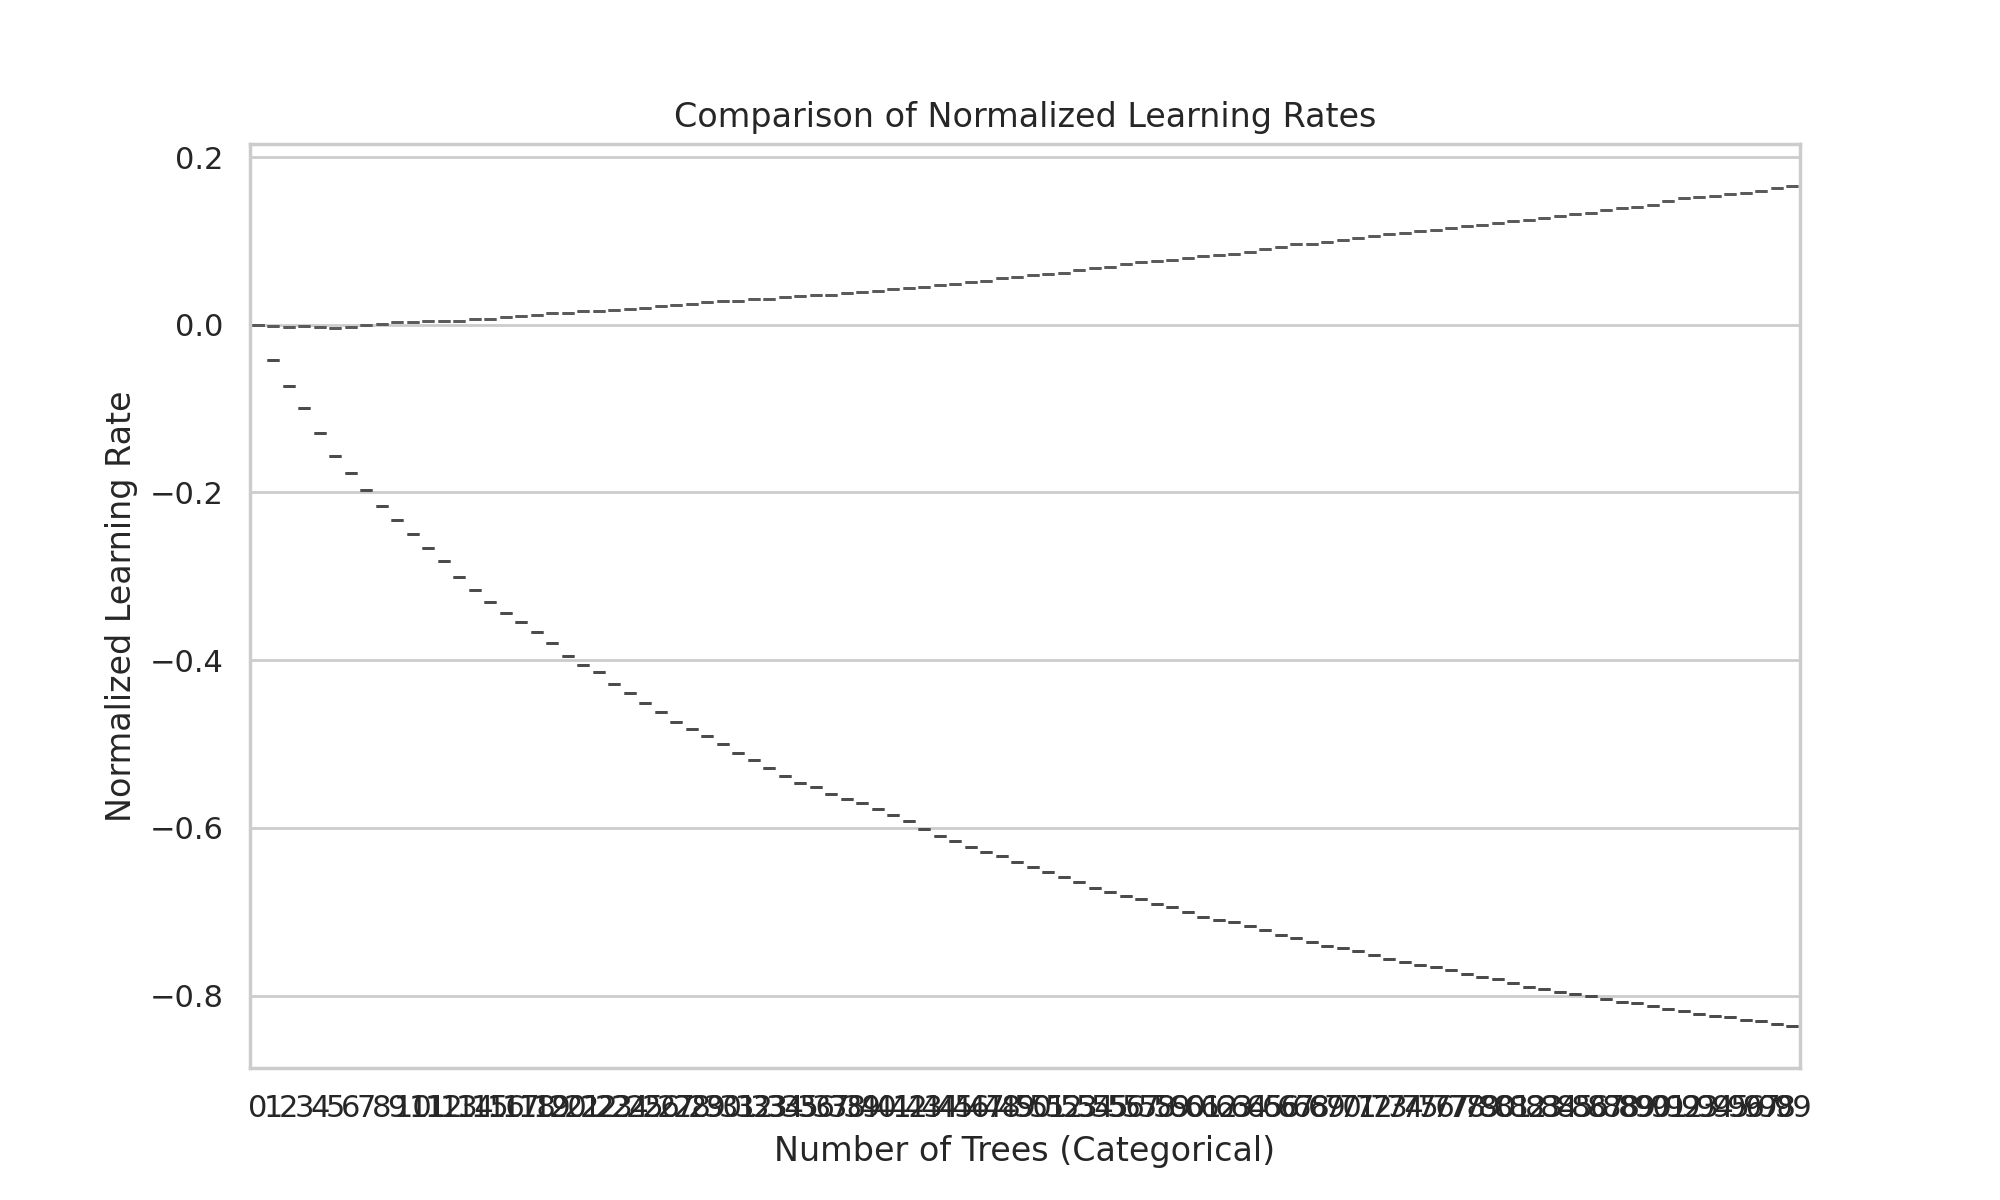

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(x='n_trees', y='normalized_learning_rate', data=learning_rates_train, ax=ax)
sns.boxplot(x='n_trees', y='normalized_learning_rate', data=learning_rates_test, ax=ax)

ax.set_title('Comparison of Normalized Learning Rates')
ax.set_xlabel('Number of Trees (Categorical)')
ax.set_ylabel('Normalized Learning Rate')

plt.show()

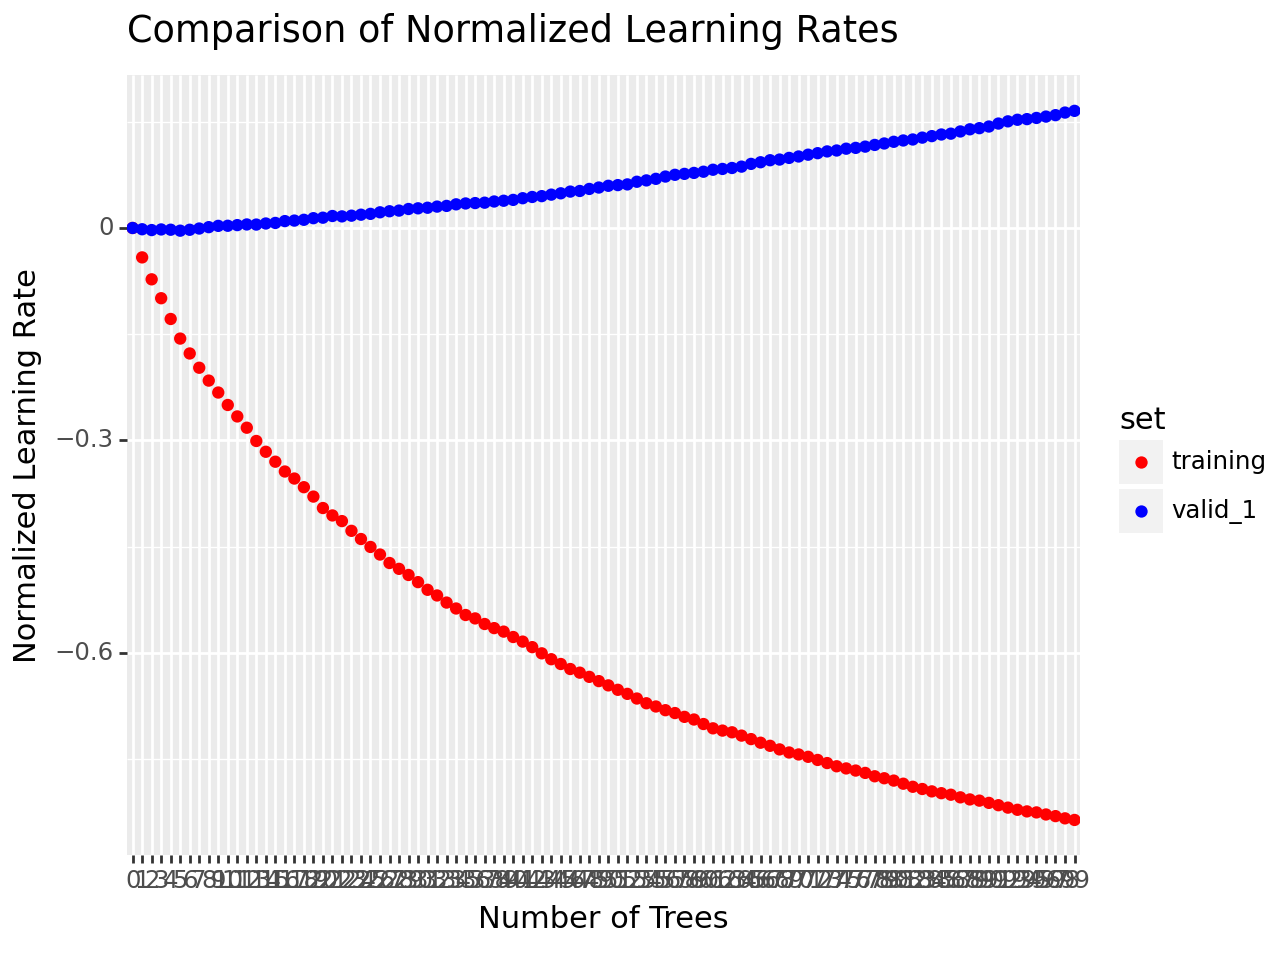

In [98]:
from plotnine import ggplot, aes, geom_boxplot, labs, scale_color_manual

combined_data = pd.concat([learning_rates_train, learning_rates_test])

combined_data["n_trees_cat"] = pd.Categorical(
    combined_data["n_trees"],
    categories=sorted(combined_data["n_trees"].unique()),
)


plot = (
    ggplot(combined_data, aes(x='n_trees_cat', y='normalized_learning_rate', color='set')) +
    geom_point() +
    labs(title='Comparison of Normalized Learning Rates',
         x='Number of Trees',
         y='Normalized Learning Rate') +
    scale_color_manual(values=["red", "blue"])
)

print(plot)

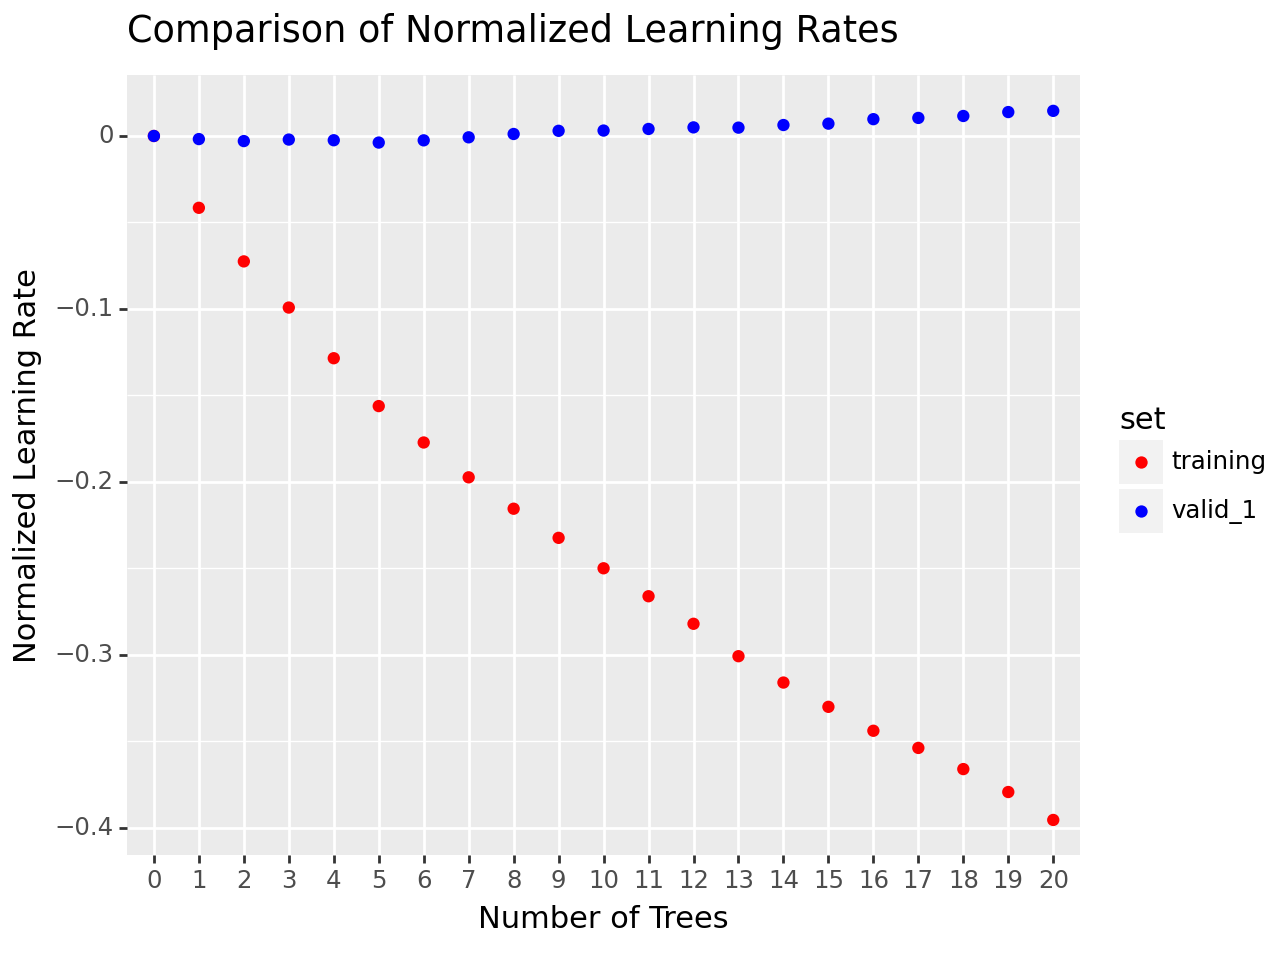

In [99]:
learning_rates_train = learning_rates_train[learning_rates_train['n_trees'] <= 20]
learning_rates_test= learning_rates_test[learning_rates_test['n_trees'] <= 20]


combined_data = pd.concat([learning_rates_train, learning_rates_test])

combined_data["n_trees_cat"] = pd.Categorical(
    combined_data["n_trees"],
    categories=sorted(combined_data["n_trees"].unique()),
)


plot = (
    ggplot(combined_data, aes(x='n_trees_cat', y='normalized_learning_rate', color='set')) +
    geom_point() +
    labs(title='Comparison of Normalized Learning Rates',
         x='Number of Trees',
         y='Normalized Learning Rate') +
    scale_color_manual(values=["red", "blue"])
)

print(plot)

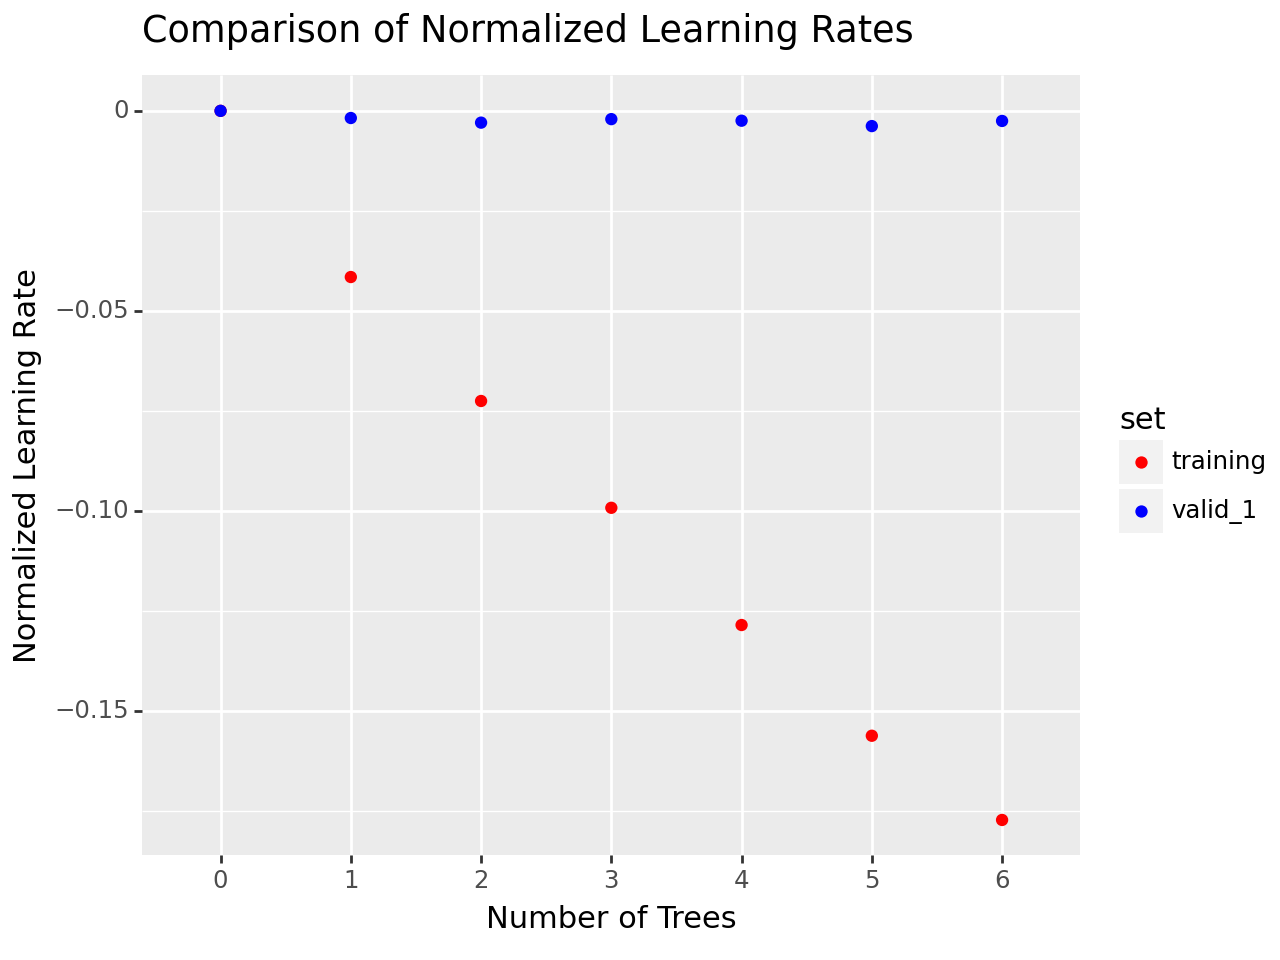

In [100]:
learning_rates_train = learning_rates_train[learning_rates_train['n_trees'] <= 6]
learning_rates_test= learning_rates_test[learning_rates_test['n_trees'] <= 6]


combined_data = pd.concat([learning_rates_train, learning_rates_test])

combined_data["n_trees_cat"] = pd.Categorical(
    combined_data["n_trees"],
    categories=sorted(combined_data["n_trees"].unique()),
)


plot = (
    ggplot(combined_data, aes(x='n_trees_cat', y='normalized_learning_rate', color='set')) +
    geom_point() +
    labs(title='Comparison of Normalized Learning Rates',
         x='Number of Trees',
         y='Normalized Learning Rate') +
    scale_color_manual(values=["red", "blue"])
)

print(plot)

In [382]:
def calculate_uplift(target, y_pred_proba):
    """
    Calculate the uplift for each decile.

    Args:
    - y_true (array-like): True labels.
    - y_pred_proba (array-like): Predicted probabilities.

    Returns:
    - pd.Series: Uplift for each decile.
    """
    data = pd.DataFrame({"y_true": target, "y_pred_proba": y_pred_proba})
    data_sorted = data.sort_values(by="y_pred_proba", ascending=False)
    try:
        data_sorted["decile"] = pd.qcut(data_sorted["y_pred_proba"], q=10, labels=list(reversed(range(10))))
    except ValueError:
        # Handle fewer bins than desired
        bins = pd.qcut(data_sorted["y_pred_proba"], q=137, duplicates='drop').categories
        unique_bins = len(bins)
        labels = list(reversed(range(unique_bins-1)))  # Create one less label
        data_sorted["decile"] = pd.qcut(data_sorted["y_pred_proba"], q=unique_bins, labels=labels, duplicates='drop')
    decile_churn_rate = data_sorted.groupby("decile", observed=True)["y_true"].mean()

    overall_churn_rate = data["y_true"].mean()
    uplift = decile_churn_rate / overall_churn_rate

    # return by ascending deciles
    return uplift.sort_index(ascending=False)


In [383]:
def evaluate_metrics_lgb(y_true, y_pred, n_trees, lr, max_depth, path_smooth, train_or_test="test"):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    uplift = calculate_uplift(y_true, y_pred)

    print(
        f"LGBM with n_trees {n_trees} n of trees and lr {lr}  and depth {max_depth} and reg {path_smooth} on {train_or_test}: Roc AUC {roc_auc:.4f} and PR AUC {pr_auc:.4f}"
    )

    print(
        f"LGBM with n_trees {n_trees} n of trees and lr {lr}  and depth {max_depth} and reg {path_smooth} on {train_or_test} {uplift[0]} Uplift on the first decile"
    )
    print(uplift)


In [384]:
lr = [0.01]
n_estimators = [6]
max_depth = [4]
path_smooth = [0, 0.25, 0.5, 2]
metric = "binary"

for r in lr:
    for n in n_estimators:
        for d in max_depth:
            for p in path_smooth:
                model = lgb.LGBMClassifier(
                learning_rate=r,
                n_estimators=n,
                max_depth=d,
                path_smooth=p,
                metric = metric,
                verbose = -1
                )
                model.fit(features, target)
                preds_train = model.predict_proba(features)[:, 1]
                preds = model.predict_proba(features_test)[:, 1]
                evaluate_metrics_lgb(target_test, preds, n, r, d, p, "test")




AttributeError: 'Series' object has no attribute 'categories'

array([0.02872447, 0.02915336, 0.02936566, ..., 0.02872447, 0.02936566,
       0.02872447])

In [334]:
preds
unique_values = np.unique(preds)
print("Number of Unique Values:", len(unique_values))

Number of Unique Values: 138


- max depth >4 works ok.
- N_trees should be >5 & <20
- low n_trees and max_depth  doesn't generate more than a few deciles -> model underfits

In [230]:
lr = [0.01, 0.1]
n_estimators = [6,7]
max_depth = [4,5, 6]
path_smooth = [0]
metric = "binary"

for r in lr:
    for n in n_estimators:
        for d in max_depth:
            for p in path_smooth:
                model = lgb.LGBMClassifier(
                learning_rate=r,
                n_estimators=n,
                max_depth=d,
                path_smooth=p,
                metric = metric,
                verbose = -1
                )
                model.fit(features, target)
                preds_train = model.predict_proba(features)[:, 1]
                preds = model.predict_proba(features_test)[:, 1]
                evaluate_metrics_lgb(target_test, preds, n, r, d, p, "test")

LGBM with n_trees 6 n of trees and lr 0.01  and depth 4 and reg 0 on test: Roc AUC 0.5668 and PR AUC 0.0583
LGBM with n_trees 6 n of trees and lr 0.01  and depth 4 and reg 0 on test 1.5188275098463142 Uplift on the first decile
decile
0    1.518828
1    0.934128
2    0.895788
Name: y_true, dtype: float64
LGBM with n_trees 6 n of trees and lr 0.01  and depth 5 and reg 0 on test: Roc AUC 0.5581 and PR AUC 0.0565
LGBM with n_trees 6 n of trees and lr 0.01  and depth 5 and reg 0 on test 1.4803974099016282 Uplift on the first decile
decile
0    1.480397
1    0.690062
2    0.898019
Name: y_true, dtype: float64
LGBM with n_trees 6 n of trees and lr 0.01  and depth 6 and reg 0 on test: Roc AUC 0.5760 and PR AUC 0.0560
LGBM with n_trees 6 n of trees and lr 0.01  and depth 6 and reg 0 on test 1.4938581534635178 Uplift on the first decile
decile
0    1.493858
1    1.157472
2    1.451524
3    0.912899
4    0.877877
5    0.551349
6    0.886562
Name: y_true, dtype: float64
LGBM with n_trees 7 n of t

In [145]:
lr = [0.01, 0.1]
n_estimators = [6, 10, 15]
max_depth = [5, 6]
path_smooth = [0.1, 0.3, 1]
metric = "binary"

for r in lr:
    for n in n_estimators:
        for d in max_depth:
            for p in path_smooth:
                model = lgb.LGBMClassifier(
                learning_rate=r,
                n_estimators=n,
                max_depth=d,
                path_smooth=p,
                metric = metric,
                verbose = -1
                )
                model.fit(features, target)
                preds_train = model.predict_proba(features)[:, 1]
                preds = model.predict_proba(features_test)[:, 1]
                evaluate_metrics_lgb(target_test, preds, n, r, d, p, "test")




LGBM with n_trees 5 n of trees and lr 0.01  and depth 4 and reg 0.1 on test: Roc AUC 0.5448 and PR AUC 0.0573
LGBM with n_trees 5 n of trees and lr 0.01  and depth 4 and reg 0.1 on test 1.0 Uplift on the first decile
decile
0    1.0
Name: y_true, dtype: float64
LGBM with n_trees 5 n of trees and lr 0.01  and depth 4 and reg 0.3 on test: Roc AUC 0.5448 and PR AUC 0.0573
LGBM with n_trees 5 n of trees and lr 0.01  and depth 4 and reg 0.3 on test 1.0 Uplift on the first decile
decile
0    1.0
Name: y_true, dtype: float64
LGBM with n_trees 5 n of trees and lr 0.01  and depth 4 and reg 1 on test: Roc AUC 0.5448 and PR AUC 0.0573
LGBM with n_trees 5 n of trees and lr 0.01  and depth 4 and reg 1 on test 1.0 Uplift on the first decile
decile
0    1.0
Name: y_true, dtype: float64
LGBM with n_trees 5 n of trees and lr 0.01  and depth 5 and reg 0.1 on test: Roc AUC 0.5556 and PR AUC 0.0559
LGBM with n_trees 5 n of trees and lr 0.01  and depth 5 and reg 0.1 on test 1.484675658453321 Uplift on the 

In [148]:
lr = [0.05, 0.1]
n_estimators = [6, 8, 10, 15]
max_depth = [5, 6]
path_smooth = [0.1, 0.5, 2]
metric = "binary"

for r in lr:
    for n in n_estimators:
        for d in max_depth:
            for p in path_smooth:
                model = lgb.LGBMClassifier(
                learning_rate=r,
                n_estimators=n,
                max_depth=d,
                path_smooth=p,
                metric = metric,
                verbose = -1
                )
                model.fit(features, target)
                preds_train = model.predict_proba(features)[:, 1]
                preds = model.predict_proba(features_test)[:, 1]
                evaluate_metrics_lgb(target_test, preds, n, r, d, p, "test")




LGBM with n_trees 6 n of trees and lr 0.05  and depth 5 and reg 0.1 on test: Roc AUC 0.6031 and PR AUC 0.0570
LGBM with n_trees 6 n of trees and lr 0.05  and depth 5 and reg 0.1 on test 1.644454105844281 Uplift on the first decile
decile
0    1.644454
1    1.167530
2    1.231504
3    1.093007
4    1.440317
5    0.877785
6    0.766736
7    0.825610
8    0.300520
Name: y_true, dtype: float64
LGBM with n_trees 6 n of trees and lr 0.05  and depth 5 and reg 0.5 on test: Roc AUC 0.6033 and PR AUC 0.0569
LGBM with n_trees 6 n of trees and lr 0.05  and depth 5 and reg 0.5 on test 1.644454105844281 Uplift on the first decile
decile
0    1.644454
1    1.176971
2    1.229561
3    1.111037
4    1.417637
5    0.874228
6    0.768648
7    0.825610
8    0.300520
Name: y_true, dtype: float64
LGBM with n_trees 6 n of trees and lr 0.05  and depth 5 and reg 2 on test: Roc AUC 0.6027 and PR AUC 0.0576
LGBM with n_trees 6 n of trees and lr 0.05  and depth 5 and reg 2 on test 1.6634862174453156 Uplift on the

In [ ]:
# Histograma de las probabilidades
plt.hist(preds_train, bins=50, alpha=0.5, label='Train')
plt.hist(preds, bins=50, alpha=0.5, label='Test')
plt.xlabel('Probabilidad Predicha de Churn')
plt.ylabel('Frecuencia')
plt.title('Distribución de las Probabilidades de Churn')
plt.legend()
plt.show()


In [ ]:
num_leaves = 12
max_depth = -1
learning_rate = 0.005

In [233]:


lr = [0.01]
n_estimators = [200]
max_depth = [4]
path_smooth = [0]
metric = "binary"

for r in lr:
    for n in n_estimators:
        for d in max_depth:
            for p in path_smooth:
                model = lgb.LGBMClassifier(
                learning_rate=r,
                n_estimators=n,
                max_depth=d,
                path_smooth=p,
                metric = metric,
                verbose = -1
                )
                model.fit(features, target,
                eval_set=[(features, target), (features_test, target_test)],
                    eval_metric = 'logloss',
            )
                preds_train = model.predict_proba(features)[:, 1]
                preds = model.predict_proba(features_test)[:, 1]
                evaluate_metrics_lgb(target_test, preds, n, r, d, p, "test")

         
evals_result = model.evals_result_

LGBM with n_trees 200 n of trees and lr 0.01  and depth 4 and reg 0 on test: Roc AUC 0.6144 and PR AUC 0.0603
LGBM with n_trees 200 n of trees and lr 0.01  and depth 4 and reg 0 on test 2.0030100394729726 Uplift on the first decile
decile
0    2.003010
1    1.238100
2    1.120186
3    1.119329
4    0.930066
5    0.995417
6    0.844406
7    0.766443
8    0.805748
9    0.176736
Name: y_true, dtype: float64


In [234]:
preds
unique_values = np.unique(preds)
print("Number of Unique Values:", len(unique_values))


Number of Unique Values: 12100


In [219]:
preds.shape[0]

13074

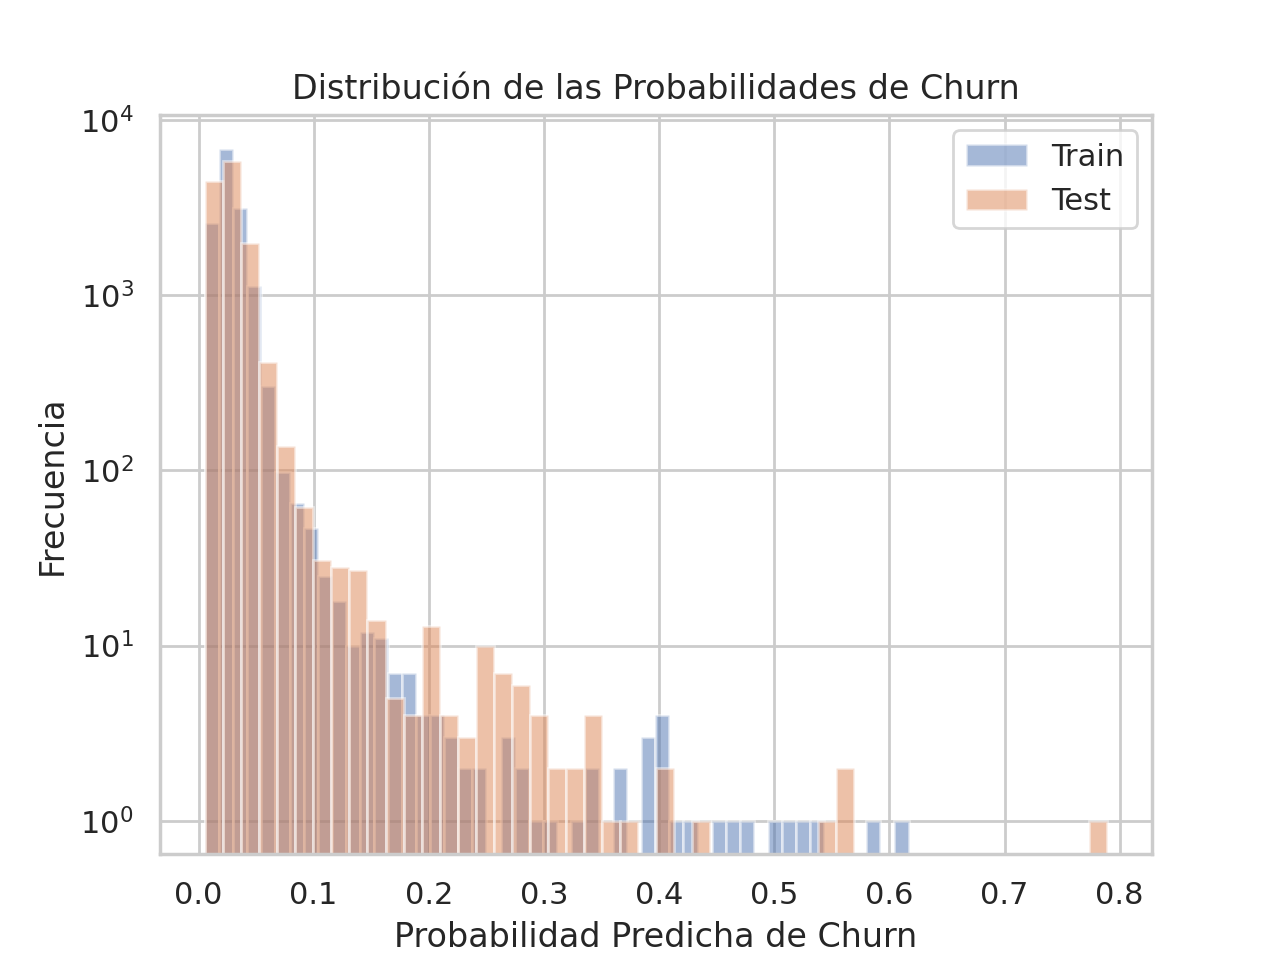

In [235]:
# Histograma de las probabilidades
plt.hist(preds_train, bins=50, alpha=0.5, label='Train')
plt.hist(preds, bins=50, alpha=0.5, label='Test')
plt.xlabel('Probabilidad Predicha de Churn')
plt.ylabel('Frecuencia')
plt.title('Distribución de las Probabilidades de Churn')
plt.yscale('log')

plt.legend()
plt.show()


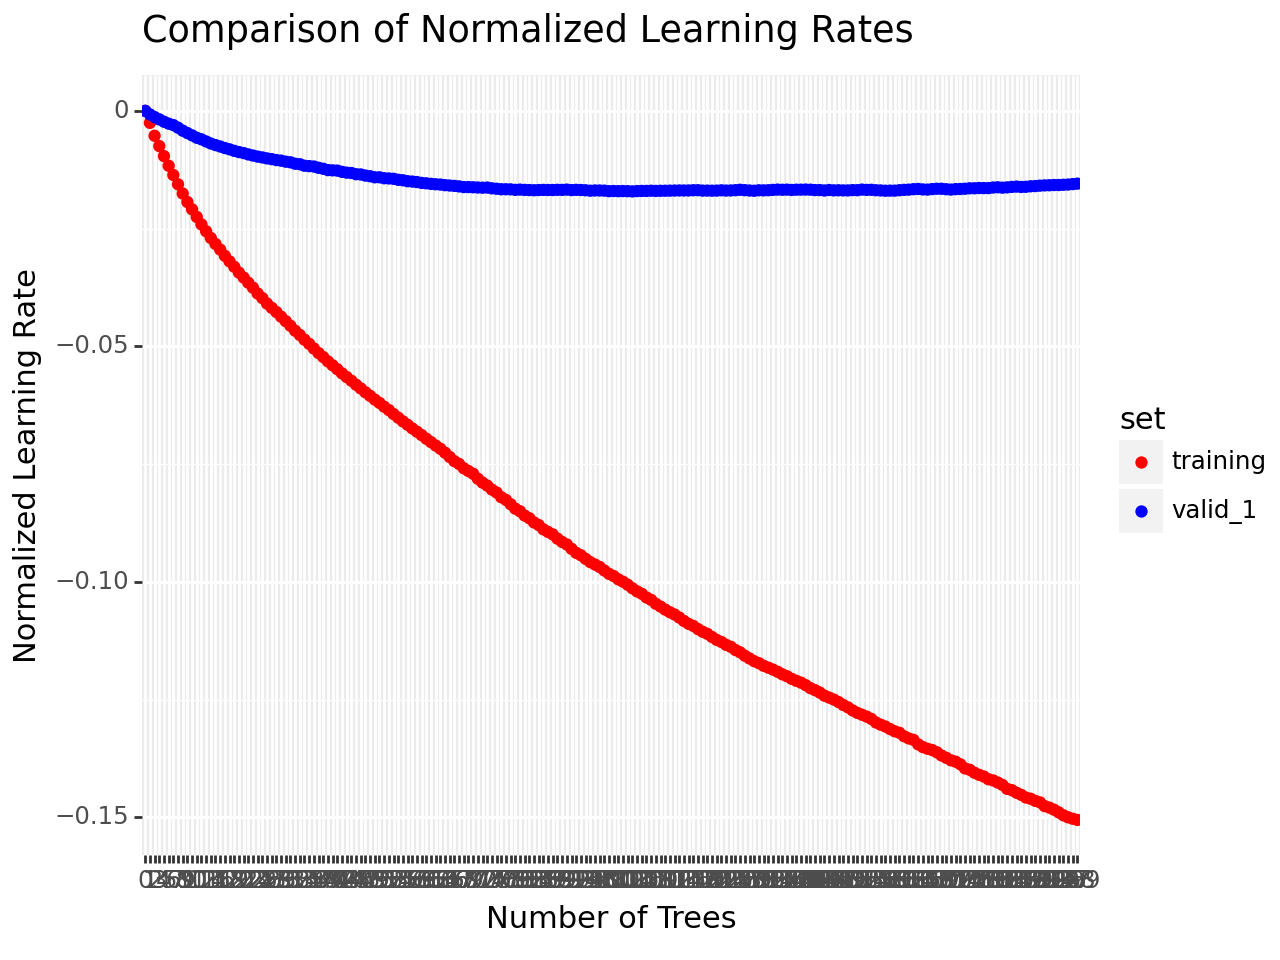

In [236]:
learning_rates_train = compute_learning_rate(evals_result, 'training')
learning_rates_test = compute_learning_rate(evals_result, 'valid_1')

#learning_rates_train = learning_rates_train[learning_rates_train['n_trees'] <= 75]
#learning_rates_test= learning_rates_test[learning_rates_test['n_trees'] <= 75]


combined_data = pd.concat([learning_rates_train, learning_rates_test])

combined_data["n_trees_cat"] = pd.Categorical(
    combined_data["n_trees"],
    categories=sorted(combined_data["n_trees"].unique()),
)


plot = (
    ggplot(combined_data, aes(x='n_trees_cat', y='normalized_learning_rate', color='set')) +
    geom_point() +
    labs(title='Comparison of Normalized Learning Rates',
         x='Number of Trees',
         y='Normalized Learning Rate') +
    scale_color_manual(values=["red", "blue"])
)

print(plot)

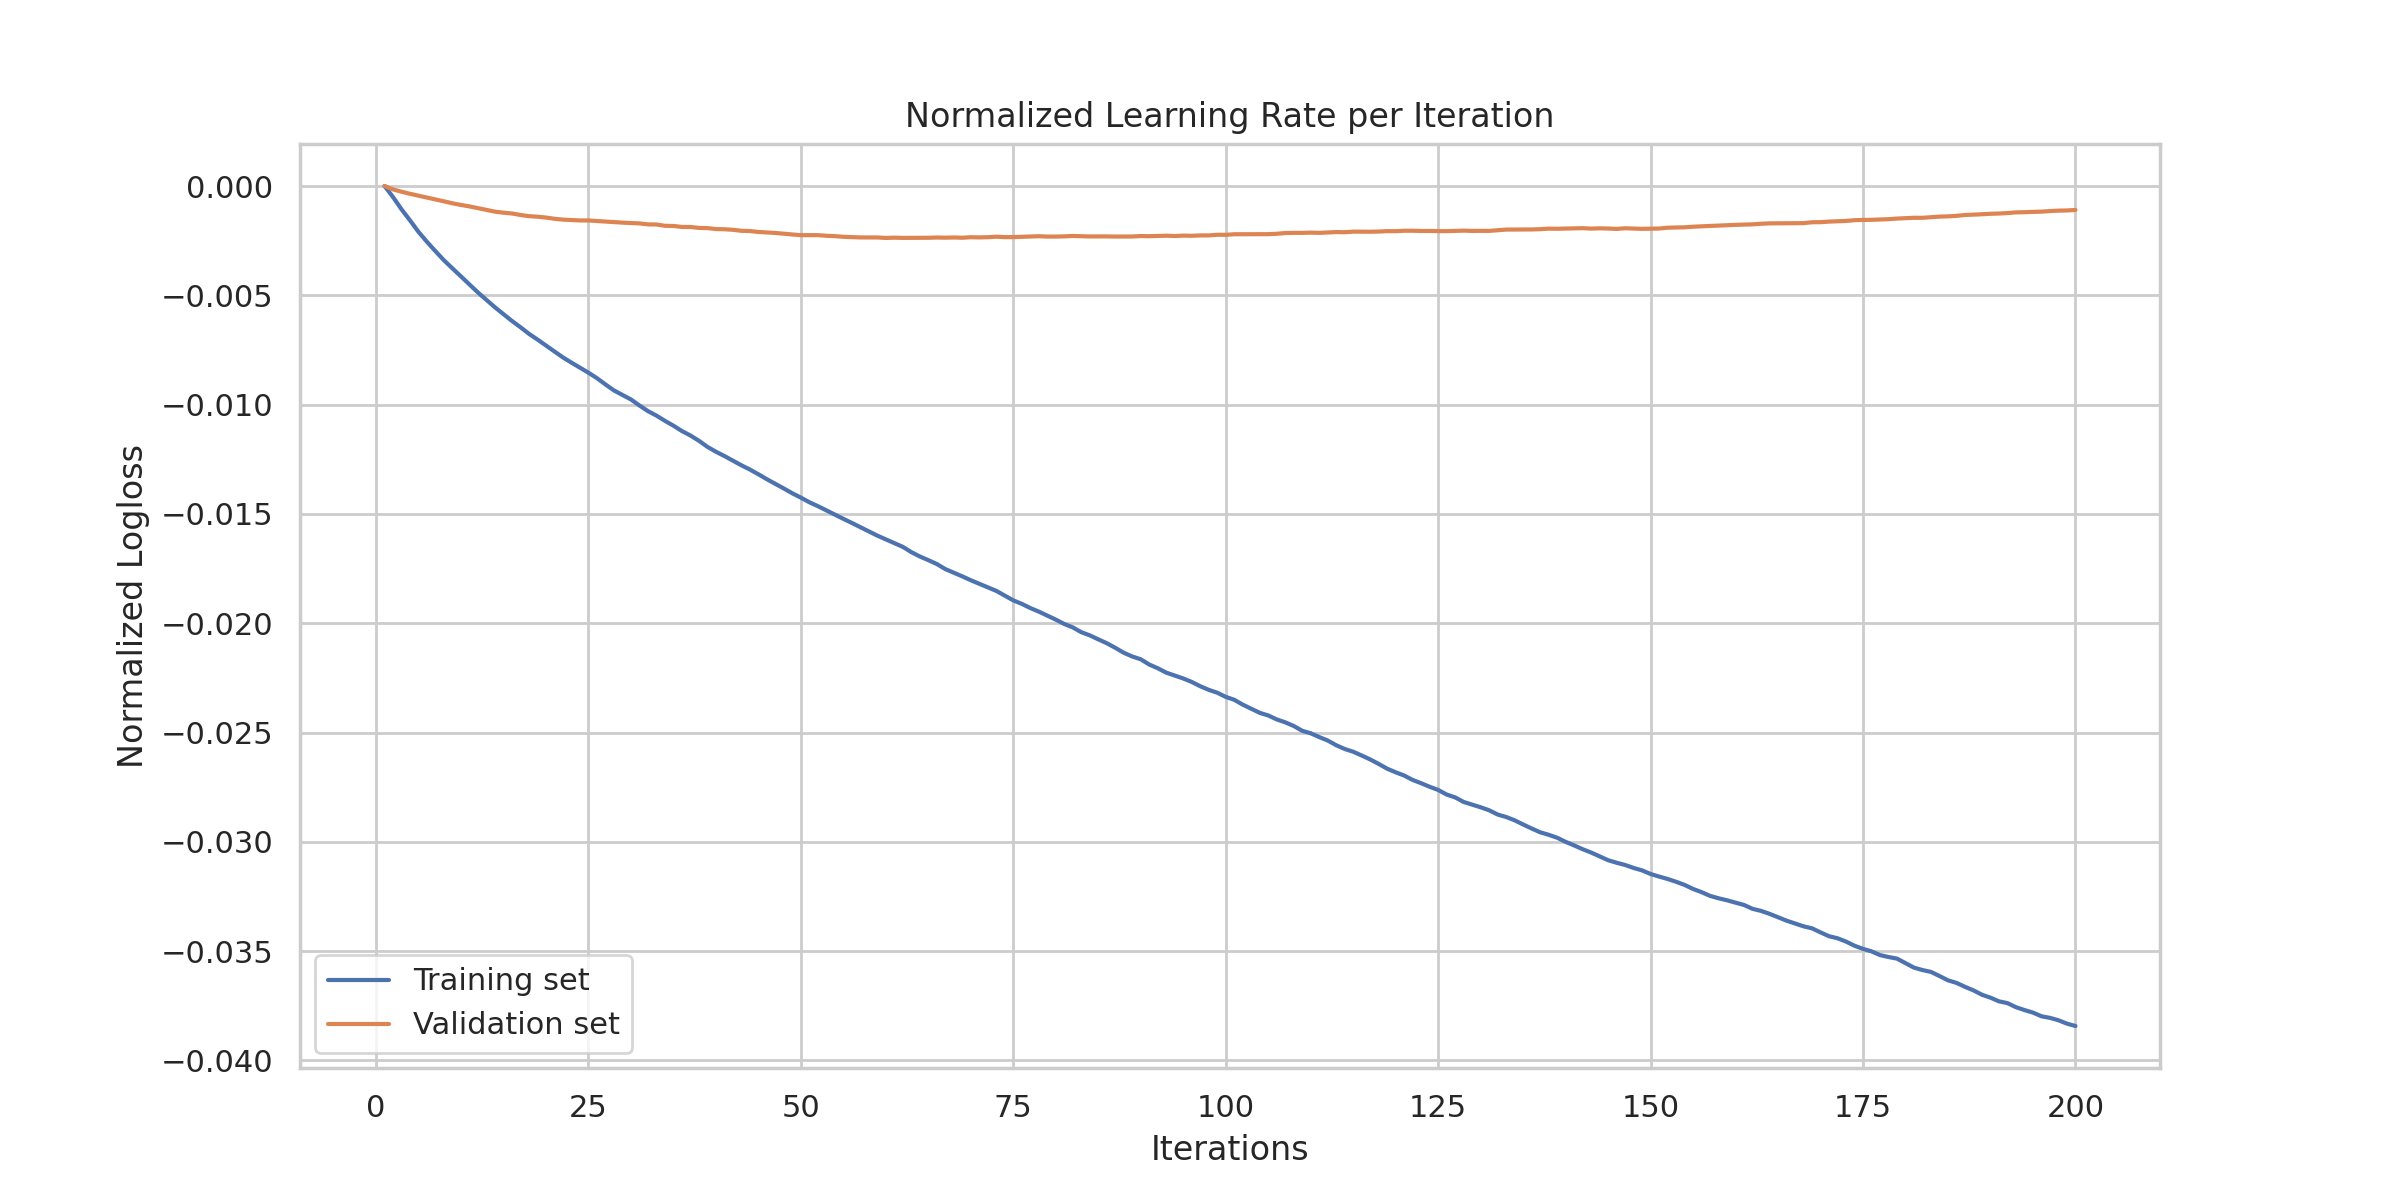

In [237]:
normalized_train_logloss = [x - train_logloss[0] for x in train_logloss]
normalized_valid_logloss = [x - valid_logloss[0] for x in valid_logloss]

# Create a range for the number of iterations
iterations = list(range(1, len(train_logloss) + 1))

# Plotting the normalized learning rate
plt.figure(figsize=(12, 6))
plt.plot(iterations, normalized_train_logloss, label='Training set')
plt.plot(iterations, normalized_valid_logloss, label='Validation set')
plt.xlabel('Iterations')
plt.ylabel('Normalized Logloss')
plt.title('Normalized Learning Rate per Iteration')
plt.legend()
plt.show()

In [288]:
lr = [0.01]
n_estimators = [100]
max_depth = [5]
path_smooth = [0.2]
metric = "binary"
reg_alpha = 0
reg_lambda = 0

for r in lr:
    for n in n_estimators:
        for d in max_depth:
            for p in path_smooth:
                model = lgb.LGBMClassifier(
                learning_rate=r,
                n_estimators=n,
                max_depth=d,
                path_smooth=p,
                metric = metric,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                verbose = -1
                )
                model.fit(features, target,
                eval_set=[(features, target), (features_test, target_test)],
                    eval_metric = 'logloss',
            )
                preds_train = model.predict_proba(features)[:, 1]
                preds = model.predict_proba(features_test)[:, 1]
                evaluate_metrics_lgb(target_test, preds, n, r, d, p, "test")

         
evals_result = model.evals_result_

LGBM with n_trees 100 n of trees and lr 0.001  and depth 5 and reg 0.2 on test: Roc AUC 0.5904 and PR AUC 0.0582
LGBM with n_trees 100 n of trees and lr 0.001  and depth 5 and reg 0.2 on test 1.5285330312051781 Uplift on the first decile
decile
0    1.528533
1    0.957415
2    0.942150
3    0.634791
Name: y_true, dtype: float64


In [289]:
preds
unique_values = np.unique(preds)
print("Number of Unique Values:", len(unique_values))


Number of Unique Values: 474


In [293]:
len(preds)

13074

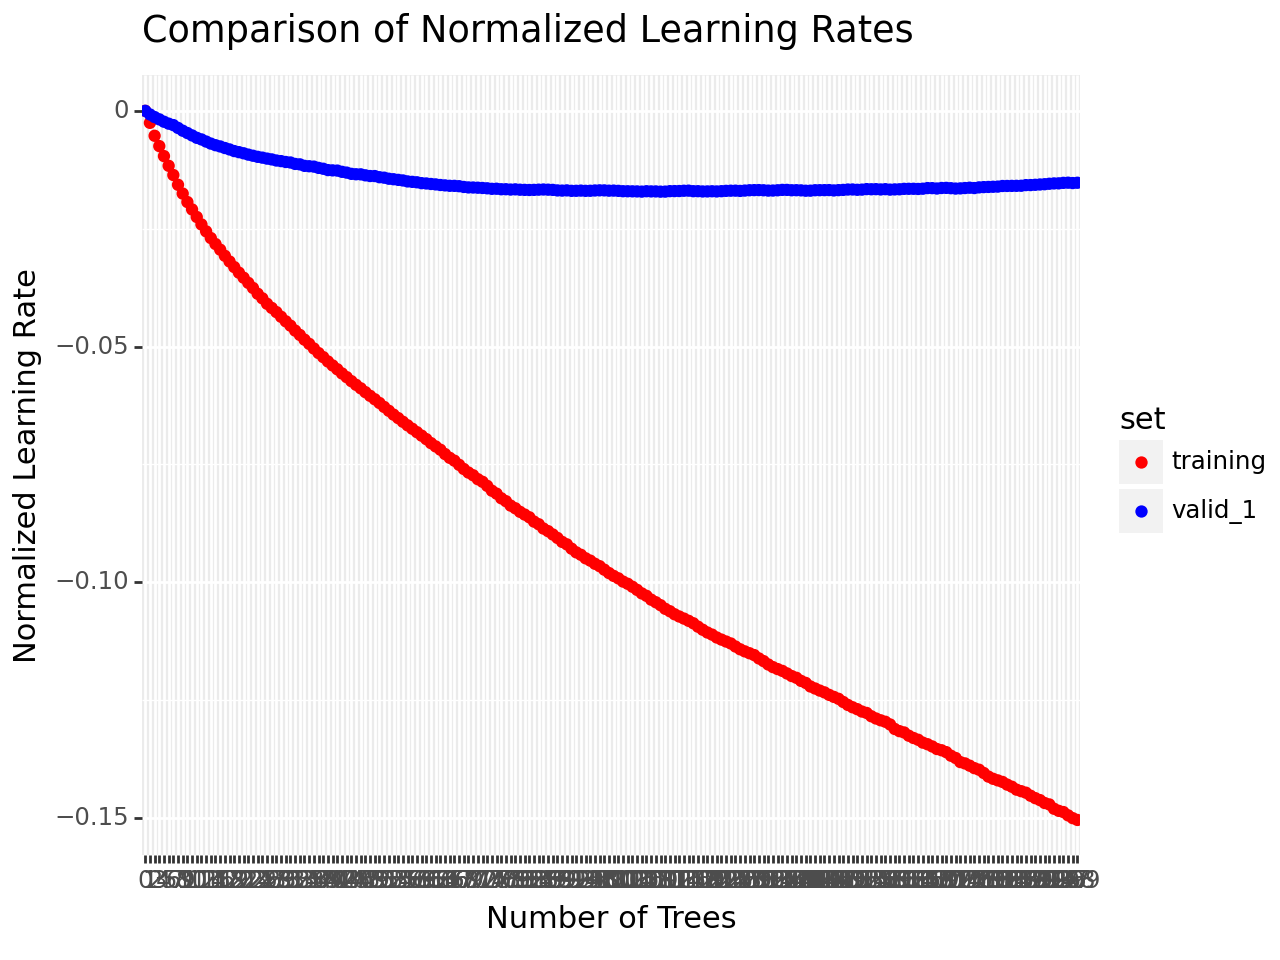

In [281]:
learning_rates_train = compute_learning_rate(evals_result, 'training')
learning_rates_test = compute_learning_rate(evals_result, 'valid_1')

#learning_rates_train = learning_rates_train[learning_rates_train['n_trees'] <= 75]
#learning_rates_test= learning_rates_test[learning_rates_test['n_trees'] <= 75]


combined_data = pd.concat([learning_rates_train, learning_rates_test])

combined_data["n_trees_cat"] = pd.Categorical(
    combined_data["n_trees"],
    categories=sorted(combined_data["n_trees"].unique()),
)


plot = (
    ggplot(combined_data, aes(x='n_trees_cat', y='normalized_learning_rate', color='set')) +
    geom_point() +
    labs(title='Comparison of Normalized Learning Rates',
         x='Number of Trees',
         y='Normalized Learning Rate') +
    scale_color_manual(values=["red", "blue"])
)

print(plot)